In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
# file_path = '/content/drive/MyDrive/gold_LSTM.csv'  # Make sure to update this path according to your actual dataset location
# df = pd.read_csv(file_path)

# Prepare the data: Assuming 'Price' is the target variable
# features = df.drop(['gold_Close', 'Date'], axis=1)  # Adjust these column names as per your dataset
# target = df[['gold_Close']]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/gold_LSTM.csv'  # Update this with your actual dataset path
df = pd.read_csv(file_path)

# Prepare the data: Assuming 'Price' is the target variable
features = df.drop(['gold_Close', 'Date'], axis=1)  # Adjust if your dataset has different columns
target = df[['gold_Close']]

# Normalize the features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target)

# Define the LSTM model structure
def create_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=6)
fold = 0
for train_index, test_index in tscv.split(scaled_features):
    fold += 1
    print(f"Fold #{fold}")

    # Split the data
    X_train, X_test = scaled_features[train_index], scaled_features[test_index]
    y_train, y_test = scaled_target[train_index], scaled_target[test_index]

    # Generate sequences for training
    look_back = 30
    train_generator = TimeseriesGenerator(np.hstack((X_train, y_train)), y_train, length=look_back, batch_size=20)
    test_generator = TimeseriesGenerator(np.hstack((X_test, y_test)), y_test, length=look_back, batch_size=1)

    # Create and train the model
    model = create_model((look_back, X_train.shape[1] + 1))  # +1 for the target variable
    model.fit(train_generator, epochs=100, verbose=0)  # Set verbose to 0 to suppress the output for simplicity

    # Evaluate the model on the test set
    test_predictions = model.predict(test_generator)
    test_predictions_inverse = scaler_target.inverse_transform(test_predictions)
    y_test_inverse = scaler_target.inverse_transform(y_test[look_back:])
    mse = np.mean(np.square(y_test_inverse - test_predictions_inverse))
    print(f"Fold #{fold} MSE: {mse}")

Fold #1
275/275 [==============================] - 1s 3ms/step
Fold #1 MSE: 768.388315617773
Fold #2
275/275 [==============================] - 1s 3ms/step
Fold #2 MSE: 564.1234604073126
Fold #3
275/275 [==============================] - 1s 3ms/step
Fold #3 MSE: 420.4919922484981
Fold #4
275/275 [==============================] - 1s 3ms/step
Fold #4 MSE: 359.5666375914168
Fold #5
275/275 [==============================] - 1s 3ms/step
Fold #5 MSE: 130.45653456561647
Fold #6
275/275 [==============================] - 1s 3ms/step
Fold #6 MSE: 171.78638040021815


399/399 [==============================] - 1s 3ms/step


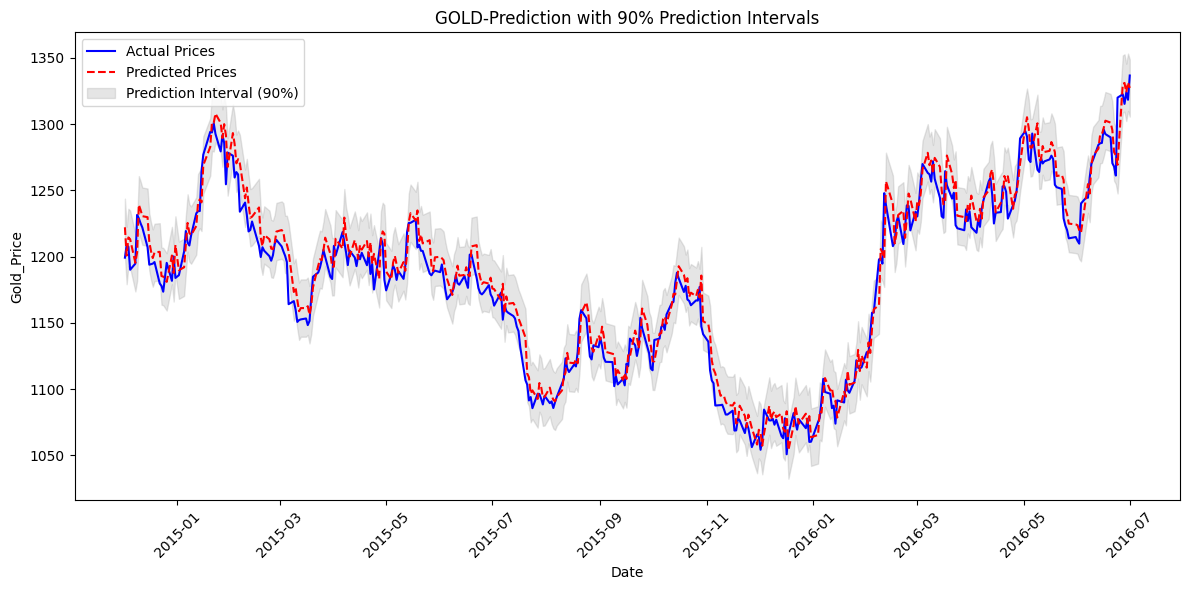

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/gold_LSTM.csv'
df = pd.read_csv(file_path)

# Prepare the data: Assuming 'Price' is the target variable
# If there are specific columns to drop (like 'Date' or non-numeric columns), adjust here
features = df.drop(['gold_Close', 'Date'], axis=1)  # Adjust if your dataset has different columns
target = df[['gold_Close']]

# Normalize the features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target)

# Split data into training+calibration and testing sets
X_train_calib, X_test, y_train_calib, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, shuffle=False)

# Further split training+calibration into separate training and calibration sets
X_train, X_calib, y_train, y_calib = train_test_split(X_train_calib, y_train_calib, test_size=0.1, shuffle=False)

# Generate sequences for training
look_back = 30
train_generator = TimeseriesGenerator(np.hstack((X_train, y_train)), y_train, length=look_back, batch_size=20)

# Model Definition with Multivariate Input
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, X_train.shape[1] + 1)),  # +1 for the target variable
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_generator, epochs=200, verbose=0)

# Prepare calibration data generator and compute nonconformity scores
calibration_generator = TimeseriesGenerator(np.hstack((X_calib, y_calib)), y_calib, length=look_back, batch_size=1)
calibration_predictions = model.predict(calibration_generator)
actual_calibration_values = np.array([y for x, y in calibration_generator])
nonconformity_scores = np.abs(calibration_predictions.flatten() - actual_calibration_values.flatten())

# Prepare the test data generator
test_generator = TimeseriesGenerator(np.hstack((X_test, y_test)), y_test, length=look_back, batch_size=1)

# Predict on the test set
test_predictions_scaled = model.predict(test_generator)

# Apply conformal prediction for a 90% confidence interval
alpha = 0.1
quantile = np.quantile(nonconformity_scores, 1 - alpha)
test_lower_bounds = test_predictions_scaled - quantile
test_upper_bounds = test_predictions_scaled + quantile

# Inverse transform to original scale
test_predictions = scaler_target.inverse_transform(test_predictions_scaled)
test_predicted_intervals_lower = scaler_target.inverse_transform(test_lower_bounds)
test_predicted_intervals_upper = scaler_target.inverse_transform(test_upper_bounds)
actual_test_prices = scaler_target.inverse_transform(y_test[look_back:])

# Visualization
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(df['Date']).iloc[-len(actual_test_prices):]  # Assumes 'Date' column for plotting
plt.plot(dates, actual_test_prices, label='Actual Prices', color='blue')
plt.plot(dates, test_predictions, label='Predicted Prices', linestyle='--', color='red')
plt.fill_between(dates, test_predicted_intervals_lower.flatten(), test_predicted_intervals_upper.flatten(), color='grey', alpha=0.2, label='Prediction Interval (90%)')
plt.title('GOLD-Prediction with 90% Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Gold_Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Assuming actual_test_prices, test_predicted_intervals_lower, and test_predicted_intervals_upper have the correct shapes
# And is_within_interval has been correctly populated as before

# Create a DataFrame from the numpy arrays
test_results_df = pd.DataFrame({
    'Actual_Price': actual_test_prices.flatten(),  # Flattening the array to ensure it matches the expected 1D shape
    'Predicted_Lower_Bound': test_predicted_intervals_lower.flatten(),
    'Predicted_Upper_Bound': test_predicted_intervals_upper.flatten(),
    'Is_Within_Interval': is_within_interval
})

# Display the first few rows of the DataFrame
display(test_results_df)

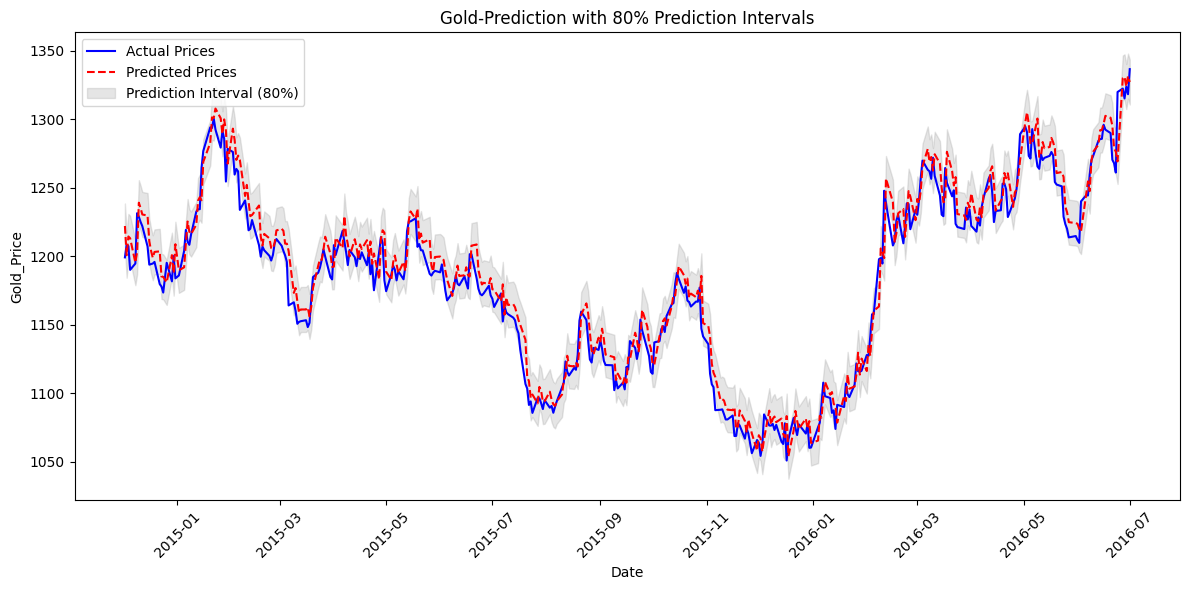

In [5]:
# Apply conformal prediction for a 80% confidence interval
alpha = 0.2
quantile = np.quantile(nonconformity_scores, 1 - alpha)
test_lower_bounds = test_predictions_scaled - quantile
test_upper_bounds = test_predictions_scaled + quantile

# Inverse transform to original scale
test_predictions = scaler_target.inverse_transform(test_predictions_scaled)
test_predicted_intervals_lower = scaler_target.inverse_transform(test_lower_bounds)
test_predicted_intervals_upper = scaler_target.inverse_transform(test_upper_bounds)
actual_test_prices = scaler_target.inverse_transform(y_test[look_back:])

# Visualization
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(df['Date']).iloc[-len(actual_test_prices):]  # Assumes 'Date' column for plotting
plt.plot(dates, actual_test_prices, label='Actual Prices', color='blue')
plt.plot(dates, test_predictions, label='Predicted Prices', linestyle='--', color='red')
plt.fill_between(dates, test_predicted_intervals_lower.flatten(), test_predicted_intervals_upper.flatten(), color='grey', alpha=0.2, label='Prediction Interval (80%)')
plt.title('Gold-Prediction with 80% Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Gold_Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


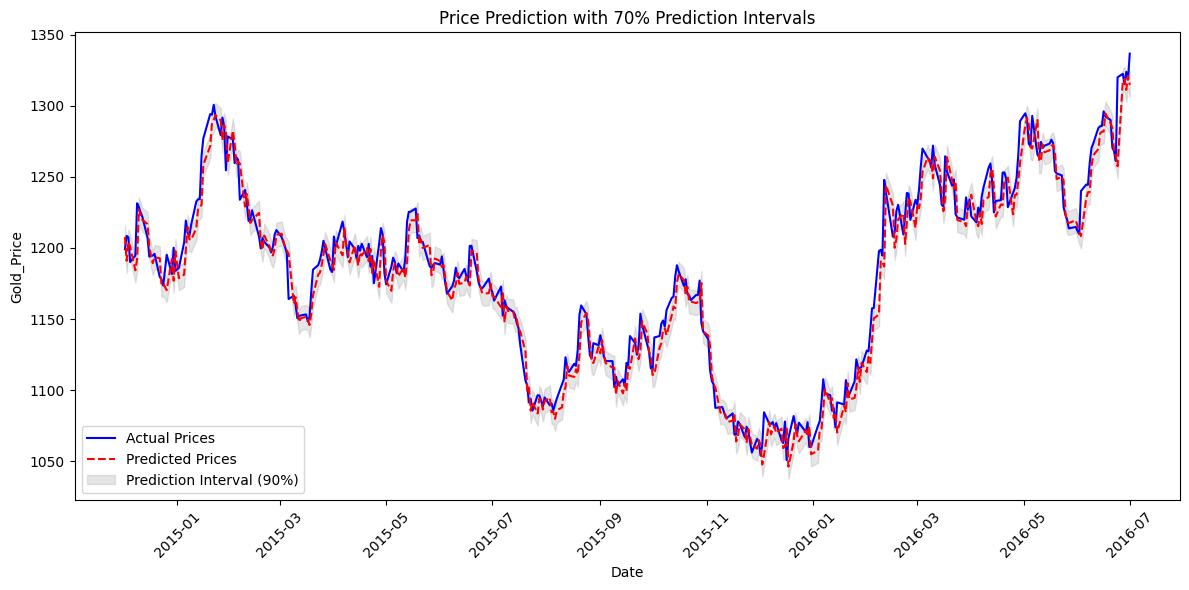

In [ ]:
# Apply conformal prediction for a 70% confidence interval
alpha = 0.3
quantile = np.quantile(nonconformity_scores, 1 - alpha)
test_lower_bounds = test_predictions_scaled - quantile
test_upper_bounds = test_predictions_scaled + quantile

# Inverse transform to original scale
test_predictions = scaler_target.inverse_transform(test_predictions_scaled)
test_predicted_intervals_lower = scaler_target.inverse_transform(test_lower_bounds)
test_predicted_intervals_upper = scaler_target.inverse_transform(test_upper_bounds)
actual_test_prices = scaler_target.inverse_transform(y_test[look_back:])

# Visualization
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(df['Date']).iloc[-len(actual_test_prices):]  # Assumes 'Date' column for plotting
plt.plot(dates, actual_test_prices, label='Actual Prices', color='blue')
plt.plot(dates, test_predictions, label='Predicted Prices', linestyle='--', color='red')
plt.fill_between(dates, test_predicted_intervals_lower.flatten(), test_predicted_intervals_upper.flatten(), color='grey', alpha=0.2, label='Prediction Interval (90%)')
plt.title('Price Prediction with 70% Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Gold_Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/sp_LSTM.csv'  # Update this with your actual dataset path
df = pd.read_csv(file_path)

# Prepare the data: Assuming 'Price' is the target variable
features = df.drop(['sp_Close', 'Date'], axis=1)  # Adjust if your dataset has different columns
target = df[['sp_Close']]

# Normalize the features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target)

# Define the LSTM model structure
def create_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=6)
fold = 0
for train_index, test_index in tscv.split(scaled_features):
    fold += 1
    print(f"Fold #{fold}")

    # Split the data
    X_train, X_test = scaled_features[train_index], scaled_features[test_index]
    y_train, y_test = scaled_target[train_index], scaled_target[test_index]

    # Generate sequences for training
    look_back = 30
    train_generator = TimeseriesGenerator(np.hstack((X_train, y_train)), y_train, length=look_back, batch_size=20)
    test_generator = TimeseriesGenerator(np.hstack((X_test, y_test)), y_test, length=look_back, batch_size=1)

    # Create and train the model
    model = create_model((look_back, X_train.shape[1] + 1))  # +1 for the target variable
    model.fit(train_generator, epochs=100, verbose=0)  # Set verbose to 0 to suppress the output for simplicity

    # Evaluate the model on the test set
    test_predictions = model.predict(test_generator)
    test_predictions_inverse = scaler_target.inverse_transform(test_predictions)
    y_test_inverse = scaler_target.inverse_transform(y_test[look_back:])
    mse = np.mean(np.square(y_test_inverse - test_predictions_inverse))
    print(f"Fold #{fold} MSE: {mse}")

Fold #1
275/275 [==============================] - 1s 3ms/step
Fold #1 MSE: 528.6708278157803
Fold #2
275/275 [==============================] - 1s 3ms/step
Fold #2 MSE: 686.3638613361252
Fold #3
275/275 [==============================] - 1s 3ms/step
Fold #3 MSE: 282.49421641906235
Fold #4
275/275 [==============================] - 1s 3ms/step
Fold #4 MSE: 216.6777495510129
Fold #5
275/275 [==============================] - 1s 3ms/step
Fold #5 MSE: 248.90816657243428
Fold #6
275/275 [==============================] - 1s 3ms/step
Fold #6 MSE: 486.9406137255045


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/drive/MyDrive/sp_LSTM.csv'
df = pd.read_csv(file_path)

# Prepare the data: Assuming 'Price' is the target variable
# If there are specific columns to drop (like 'Date' or non-numeric columns), adjust here
features = df.drop(['sp_Close', 'Date'], axis=1)  # Adjust if your dataset has different columns
target = df[['sp_Close']]

# Normalize the features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_target = scaler_target.fit_transform(target)

# Split data into training+calibration and testing sets
X_train_calib, X_test, y_train_calib, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, shuffle=False)

# Further split training+calibration into separate training and calibration sets
X_train, X_calib, y_train, y_calib = train_test_split(X_train_calib, y_train_calib, test_size=0.1, shuffle=False)

# Generate sequences for training
look_back = 30
train_generator = TimeseriesGenerator(np.hstack((X_train, y_train)), y_train, length=look_back, batch_size=20)

# Model Definition with Multivariate Input
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, X_train.shape[1] + 1)),  # +1 for the target variable
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_generator, epochs=200, verbose=0)

# Prepare calibration data generator and compute nonconformity scores
calibration_generator = TimeseriesGenerator(np.hstack((X_calib, y_calib)), y_calib, length=look_back, batch_size=1)
calibration_predictions = model.predict(calibration_generator)
actual_calibration_values = np.array([y for x, y in calibration_generator])
nonconformity_scores = np.abs(calibration_predictions.flatten() - actual_calibration_values.flatten())

# Prepare the test data generator
test_generator = TimeseriesGenerator(np.hstack((X_test, y_test)), y_test, length=look_back, batch_size=1)

# Predict on the test set
test_predictions_scaled = model.predict(test_generator)

399/399 [==============================] - 1s 2ms/step


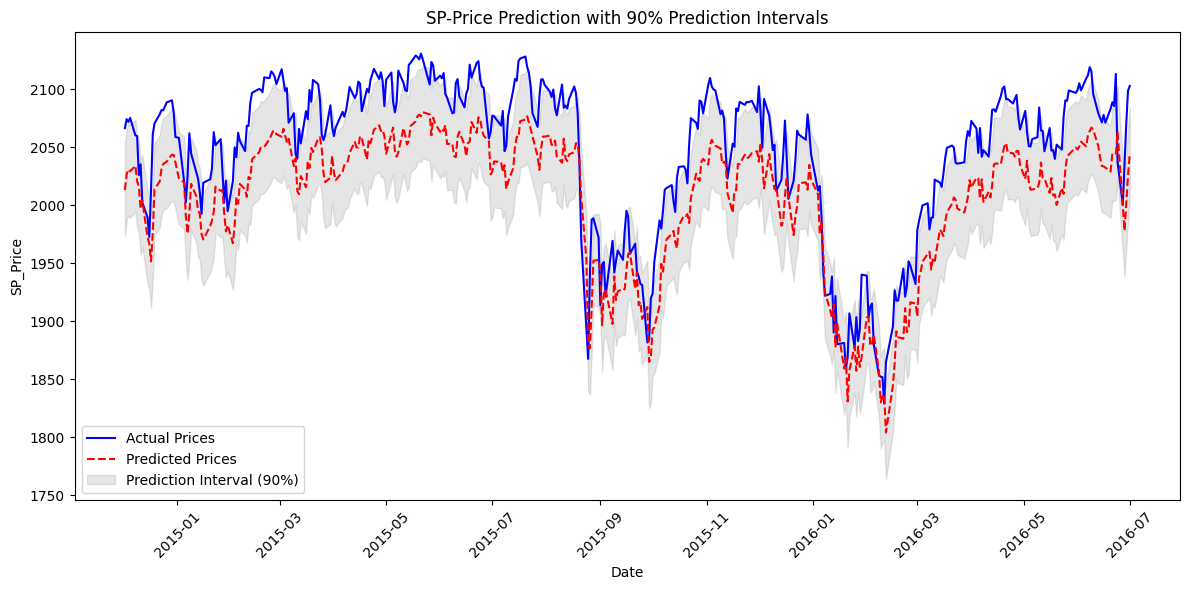

In [7]:
# Apply conformal prediction for a 90% confidence interval
alpha = 0.1
quantile = np.quantile(nonconformity_scores, 1 - alpha)
test_lower_bounds = test_predictions_scaled - quantile
test_upper_bounds = test_predictions_scaled + quantile

# Inverse transform to original scale
test_predictions = scaler_target.inverse_transform(test_predictions_scaled)
test_predicted_intervals_lower = scaler_target.inverse_transform(test_lower_bounds)
test_predicted_intervals_upper = scaler_target.inverse_transform(test_upper_bounds)
actual_test_prices = scaler_target.inverse_transform(y_test[look_back:])

# Visualization
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(df['Date']).iloc[-len(actual_test_prices):]  # Assumes 'Date' column for plotting
plt.plot(dates, actual_test_prices, label='Actual Prices', color='blue')
plt.plot(dates, test_predictions, label='Predicted Prices', linestyle='--', color='red')
plt.fill_between(dates, test_predicted_intervals_lower.flatten(), test_predicted_intervals_upper.flatten(), color='grey', alpha=0.2, label='Prediction Interval (90%)')
plt.title('SP-Price Prediction with 90% Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('SP_Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

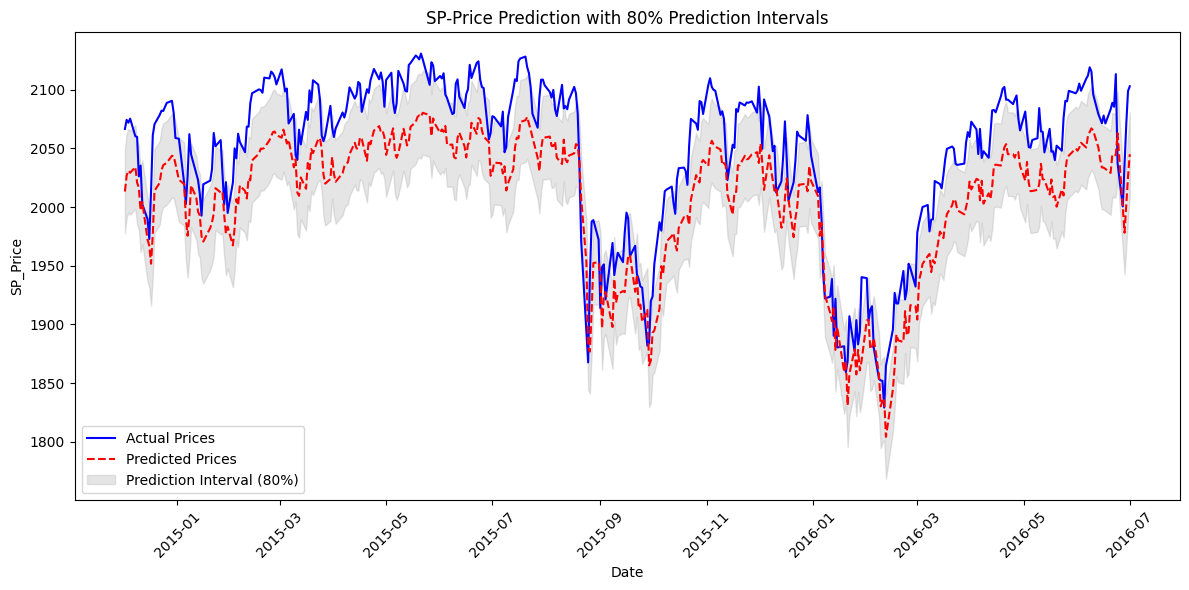

In [8]:
# Apply conformal prediction for a 90% confidence interval
alpha = 0.2
quantile = np.quantile(nonconformity_scores, 1 - alpha)
test_lower_bounds = test_predictions_scaled - quantile
test_upper_bounds = test_predictions_scaled + quantile

# Inverse transform to original scale
test_predictions = scaler_target.inverse_transform(test_predictions_scaled)
test_predicted_intervals_lower = scaler_target.inverse_transform(test_lower_bounds)
test_predicted_intervals_upper = scaler_target.inverse_transform(test_upper_bounds)
actual_test_prices = scaler_target.inverse_transform(y_test[look_back:])

# Visualization
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(df['Date']).iloc[-len(actual_test_prices):]  # Assumes 'Date' column for plotting
plt.plot(dates, actual_test_prices, label='Actual Prices', color='blue')
plt.plot(dates, test_predictions, label='Predicted Prices', linestyle='--', color='red')
plt.fill_between(dates, test_predicted_intervals_lower.flatten(), test_predicted_intervals_upper.flatten(), color='grey', alpha=0.2, label='Prediction Interval (80%)')
plt.title('SP-Price Prediction with 80% Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('SP_Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

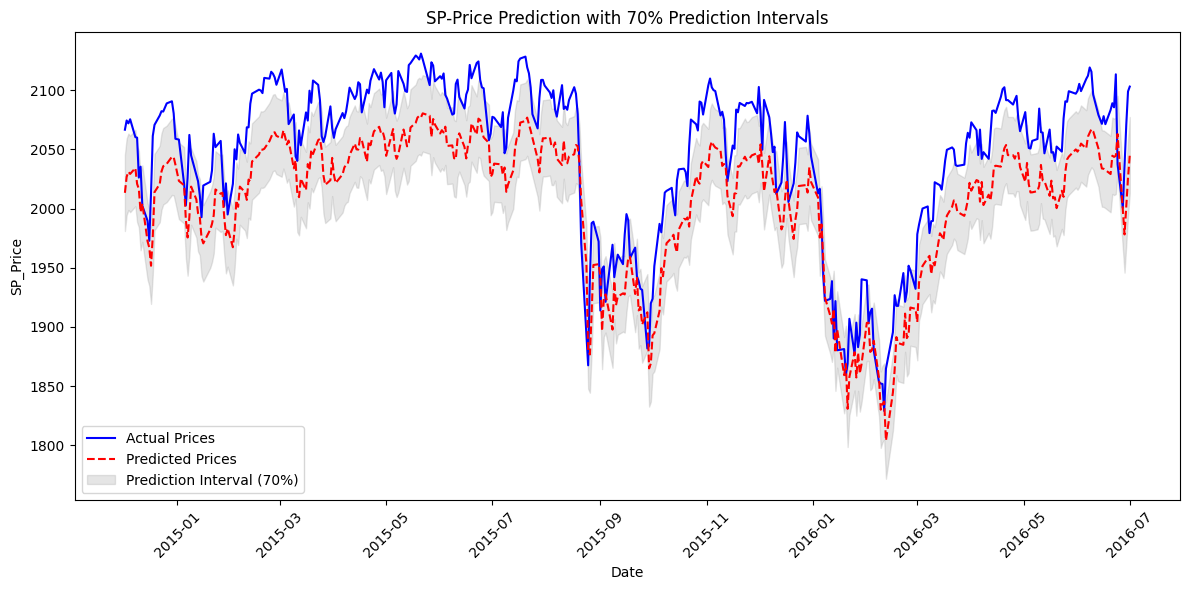

In [10]:
# Apply conformal prediction for a 90% confidence interval
alpha = 0.3
quantile = np.quantile(nonconformity_scores, 1 - alpha)
test_lower_bounds = test_predictions_scaled - quantile
test_upper_bounds = test_predictions_scaled + quantile

# Inverse transform to original scale
test_predictions = scaler_target.inverse_transform(test_predictions_scaled)
test_predicted_intervals_lower = scaler_target.inverse_transform(test_lower_bounds)
test_predicted_intervals_upper = scaler_target.inverse_transform(test_upper_bounds)
actual_test_prices = scaler_target.inverse_transform(y_test[look_back:])

# Visualization
plt.figure(figsize=(12, 6))
dates = pd.to_datetime(df['Date']).iloc[-len(actual_test_prices):]  # Assumes 'Date' column for plotting
plt.plot(dates, actual_test_prices, label='Actual Prices', color='blue')
plt.plot(dates, test_predictions, label='Predicted Prices', linestyle='--', color='red')
plt.fill_between(dates, test_predicted_intervals_lower.flatten(), test_predicted_intervals_upper.flatten(), color='grey', alpha=0.2, label='Prediction Interval (70%)')
plt.title('SP-Price Prediction with 70% Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('SP_Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()